In [1]:
# !pip install -U numpy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import gensim
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from collections import Counter
import gensim.downloader as api

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier,
                              AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, precision_score

C:\Users\ADMIN\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
def load_data(filepath, sep_type, col_1='label', col_2='message', has_header=True):
    """Load dataset from file and return a DataFrame, adjusting for headers."""
    if has_header:
        # Load with the first row as header
        return pd.read_csv(filepath, sep=sep_type, header=0)
    else:
        # Load without headers and assign column names
        return pd.read_csv(filepath, sep=sep_type, header=None, names=[col_1, col_2])

In [4]:
def preprocess_email(email):
    lemmatizer = WordNetLemmatizer()
    # Loại bỏ ký tự không mong muốn
    email_cleaned = re.sub('[^a-zA-Z]', ' ', email)
    # Chuyển thành chữ thường và tách từ
    email_cleaned = email_cleaned.lower().split()
    # Lemmatization
    email_cleaned = [lemmatizer.lemmatize(word, pos='v') for word in email_cleaned if not word in stopwords.words('english')]
    # email_cleaned = ' '.join(email_cleaned)
    
    return email_cleaned

In [5]:
def data_analist(data, corpus):
    df = pd.DataFrame(data)
    print('\n', df.isnull().sum())
    print('\n', df['label'].value_counts())
    print('\n', df.info())
    print(df.columns)
    print('\n', df['label'].value_counts()/len (df)*100)

In [6]:
def avg_word2vec(words, w2v_model):
    # Apply word2vec
    vectors = [w2v_model[word] for word in words if word in w2v_model.key_to_index]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

In [7]:
def data_preparation(messages, w2v_model):
    corpus = [preprocess_email(email) for email in messages['message']]
    X = []
    for i in range(len(corpus)):
        X.append(avg_word2vec(corpus[i], w2v_model))

    # Dependent feature
    y = pd.get_dummies(messages['label']).astype(int)
    y = y.iloc[:, 0].values

    df_list = [pd.DataFrame(X[i].reshape(1, -1)) for i in range(len(X))]
    df = pd.concat(df_list, ignore_index=True)
    df['Output'] = y
    df.dropna(inplace = True)

    # Independent feature

    X = df.drop('Output', axis=1)

    y = df['Output']

    return X, y

In [8]:
def train_classifier(classify_model, X_train, y_train, X_test, y_test):
    classify_model.fit(X_train, y_train)
    y_pred = classify_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return accuracy, precision

In [10]:
from gensim.models import KeyedVectors

messages = load_data('SMSSpamCollection.txt', '\t', has_header=False)

corpus = [preprocess_email(email) for email in messages['message']]

In [11]:
data_analist(messages, corpus)


 label      0
message    0
dtype: int64

 label
ham     4825
spam     747
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

 None
Index(['label', 'message'], dtype='object')

 label
ham     86.593683
spam    13.406317
Name: count, dtype: float64


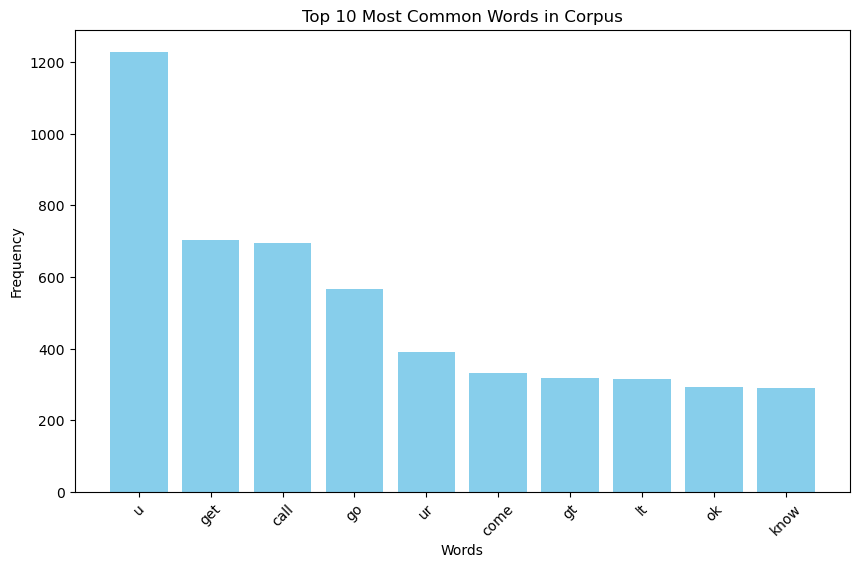

In [12]:
# Calculate word frequency
all_words = [word for email in corpus for word in email]
word_freq = Counter(all_words)
    
# Select the 10 most common words
most_common_words = word_freq.most_common(10)
words, frequencies = zip(*most_common_words)  # separate words and their counts
    
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Corpus')
plt.xticks(rotation=45)
plt.show()

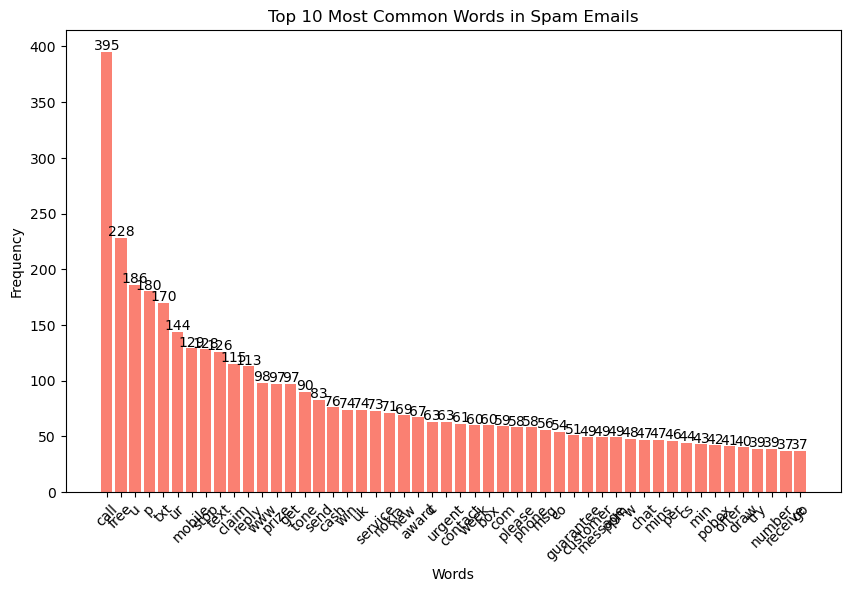

In [13]:
# Separate corpus into spam and ham messages
spam_corpus = [corpus[i] for i in range(len(corpus)) if messages['label'].iloc[i] == 'spam']
ham_corpus = [corpus[i] for i in range(len(corpus)) if messages['label'].iloc[i] == 'ham']
    
# Flatten lists and calculate word frequencies for spam and ham
spam_words = [word for email in spam_corpus for word in email]
spam_word_freq = Counter(spam_words)
    
# Get top 10 most common words in spam emails
spam_common_words = spam_word_freq.most_common(50)
spam_words, spam_frequencies = zip(*spam_common_words)
    
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(spam_words, spam_frequencies, color='salmon')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Spam Emails')
plt.xticks(rotation=45)
    
# Add frequency values on top of each bar
for bar, freq in zip(bars, spam_frequencies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 1,  # position slightly below the top of each bar
                f'{freq}', ha='center', va='bottom', fontsize=10, color='black')
    
plt.show()

In [14]:
# Print top 50 most common words in spam emails with their frequencies
print("Top 50 Most Common Words in Spam Emails:")
for word, freq in spam_common_words:
    print(f"{word}: {freq}")

Top 50 Most Common Words in Spam Emails:
call: 395
free: 228
u: 186
p: 180
txt: 170
ur: 144
mobile: 129
stop: 128
text: 126
claim: 115
reply: 113
www: 98
prize: 97
get: 97
tone: 90
send: 83
cash: 76
win: 74
uk: 74
service: 73
nokia: 71
new: 69
award: 67
c: 63
urgent: 63
contact: 61
week: 60
box: 60
com: 59
please: 58
phone: 58
msg: 56
co: 54
guarantee: 51
customer: 49
message: 49
ppm: 49
w: 48
chat: 47
mins: 47
per: 46
cs: 44
min: 43
pobox: 42
offer: 41
draw: 40
try: 39
number: 39
receive: 37
go: 37


In [15]:
from gensim.models import KeyedVectors

messages = load_data('SMSSpamCollection.txt', '\t', has_header=False)

corpus = [preprocess_email(email) for email in messages['message']]

# Use word2vec pre-trained model of Google
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [16]:
X, y = data_preparation(messages, w2v_model)

In [17]:
X

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.021864,0.037510,0.012939,0.221261,-0.038550,0.059958,0.087703,-0.083775,0.025561,0.069411,...,0.003148,0.052189,-0.106951,0.089011,0.009055,-0.030613,0.019139,-0.070439,-0.041731,0.022053
1,-0.085777,0.057678,0.044668,0.111125,-0.109212,0.063639,-0.037435,-0.063914,0.034465,0.108073,...,0.097651,0.115438,-0.148265,-0.010356,-0.184082,-0.143250,-0.170898,-0.110285,-0.098511,0.125244
2,-0.034390,0.000680,-0.055209,0.120478,0.030869,0.026186,-0.010800,-0.073505,0.079020,0.105788,...,0.030157,0.023937,-0.033200,-0.008371,-0.002994,-0.010684,-0.042822,-0.101922,-0.111270,0.039590
3,-0.065681,0.026215,0.108154,0.086975,-0.111816,0.000515,-0.044501,-0.104248,-0.005534,0.117784,...,0.033122,0.061523,-0.046231,-0.014269,-0.066461,-0.139025,-0.095494,-0.071832,-0.015137,0.110989
4,-0.005354,0.018454,0.040213,0.194406,-0.031825,0.021868,0.059169,-0.061581,0.071167,0.105384,...,0.011361,0.136091,-0.110421,0.096174,-0.089456,-0.033517,-0.011230,-0.100848,0.090654,-0.044067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,-0.021714,0.059182,0.055613,0.081737,0.029327,0.022012,0.059138,-0.080502,0.060805,0.048351,...,0.006132,0.016199,-0.092057,-0.040924,-0.079780,-0.106366,-0.082175,-0.075157,-0.010426,0.014164
5568,-0.013940,0.055859,0.084314,0.076117,-0.017090,-0.042633,-0.062476,-0.185547,0.007983,0.036625,...,-0.039453,0.107959,-0.141971,0.147693,0.014014,-0.073682,-0.017505,-0.178906,0.081934,0.080444
5569,0.044271,0.157715,0.015299,0.089518,-0.142008,-0.004150,0.053874,-0.117676,0.056478,0.096842,...,-0.250000,0.084696,0.035319,-0.127543,0.020386,0.063965,0.156809,-0.036296,-0.020426,0.007284
5570,0.105713,-0.005296,0.008970,0.129188,-0.075411,0.036372,0.094281,-0.082090,0.046422,0.100633,...,0.001295,0.099459,-0.139517,-0.004542,-0.047288,-0.017817,0.028778,-0.045399,-0.037091,-0.082923


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [19]:
# Định nghĩa các mô hình
bc = BaggingClassifier(n_estimators=50, random_state=42)
etc = ExtraTreesClassifier(n_estimators=50, random_state=42)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=42)
xgb = XGBClassifier(n_estimators=50, random_state=42)
svc = SVC(kernel="sigmoid", gamma=1.0)
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=10)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
abc = AdaBoostClassifier(n_estimators=50, random_state=42, algorithm='SAMME')
knnClassifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
# knnclassifier.fit(X_train, y_train)

classify_models = {
'Bagging': bc,
'ExtraTrees': etc,
'GradientBoosting': gbdt,
'XGBr': xgb,
'SVC': svc,
# 'MultinomialNB': mnb,
'DecisionTree': dtc,
'LogisticRegression': lrc,
'RandomForest': rfc,
'AdaBoost': abc,
'KNeighbors': knnClassifier
}

In [20]:
# Đo thời gian thực hiện
import time
start_time = time.time()

accuracy_scores = []
precision_scores = []

# Lặp qua các mô hình
for name, classify_model in classify_models.items():
    current_accuracy, current_precision = train_classifier(classify_model, X_train, y_train, X_test, y_test)
    rounded_accuracy = round(current_accuracy, 2)
    rounded_precision = round(current_precision, 2)

    print("For: ", name)
    print("Accuracy: ", rounded_accuracy)
    print("Precision: ", rounded_precision)
    print("\n")
    accuracy_scores.append(rounded_accuracy)
    precision_scores.append(rounded_precision)

# Thời gian thực hiện
end_time = time.time()
print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")
# return models, accuracy_scores, precision_scores

For:  Bagging
Accuracy:  0.97
Precision:  0.97


For:  ExtraTrees
Accuracy:  0.97
Precision:  0.96


For:  GradientBoosting
Accuracy:  0.96
Precision:  0.97


For:  XGBr
Accuracy:  0.98
Precision:  0.98


For:  SVC
Accuracy:  0.83
Precision:  0.89


For:  DecisionTree
Accuracy:  0.93
Precision:  0.96


For:  LogisticRegression
Accuracy:  0.96
Precision:  0.97


For:  RandomForest
Accuracy:  0.97
Precision:  0.96


For:  AdaBoost
Accuracy:  0.96
Precision:  0.97


For:  KNeighbors
Accuracy:  0.97
Precision:  0.99



Total execution time: 75.70 seconds


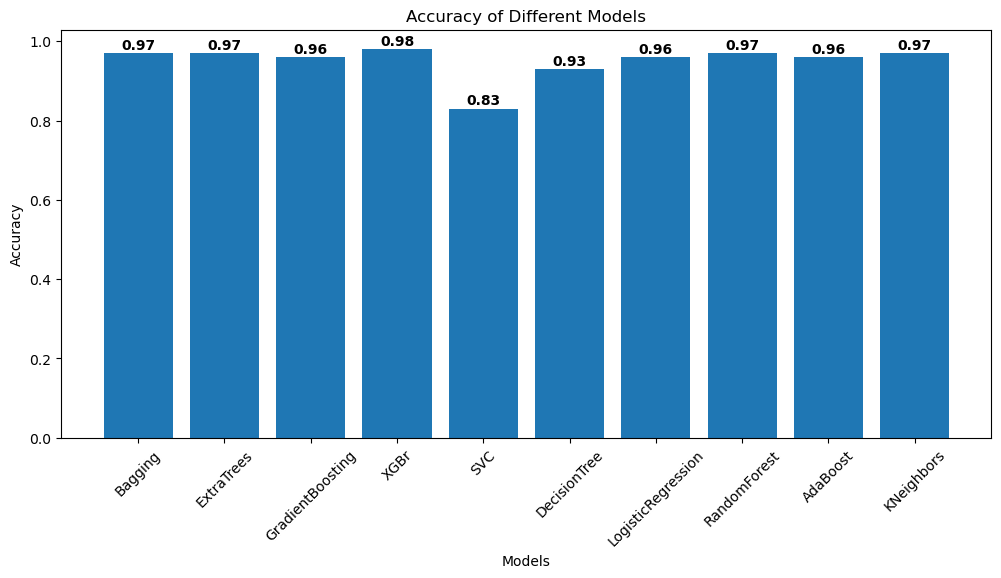

In [21]:
model_names = list(classify_models.keys())
def plot_model_accuracy(model_names, accuracy_scores):
      # Tạo hình vẽ
      fig, ax = plt.subplots(figsize=(12, 6))

      # Vẽ biểu đồ cột
      ax.bar(model_names, accuracy_scores)

      # Thêm tiêu đề và nhãn trục
      ax.set_title("Accuracy of Different Models")
      ax.set_xlabel("Models")
      ax.set_ylabel("Accuracy")

      # Xoay nhãn trục x để tránh chồng lấn
      plt.xticks(rotation=45)

      # Hiển thị giá trị độ chính xác trên mỗi cột
      for i, v in enumerate(accuracy_scores):
          ax.text(i, v + 0.01, str(round(v, 2)), color='black', ha='center', fontweight='bold')

      # Điều chỉnh khoảng cách giữa các cột
      plt.subplots_adjust(bottom=0.2)

      # Hiển thị biểu đồ
      plt.show()

plot_model_accuracy(model_names, accuracy_scores)